<a href="https://colab.research.google.com/github/ttma333/python/blob/main/%EC%8B%9C%EA%B3%84%EC%97%B4_%EA%B8%B0%EC%98%A8%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd/content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-12-14 05:32:31--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.242.22, 52.216.43.160, 52.216.178.85, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.242.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.37MB/s    in 2.0s    

2022-12-14 05:32:34 (6.37 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import pandas as pd
raw_data=pd.read_csv('jena_climate_2009_2016.csv')
raw_data=raw_data.iloc[:,1:]
raw_data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
temperature = pd.DataFrame(raw_data['T (degC)'])

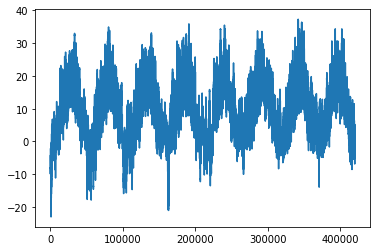

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperature)),temperature)

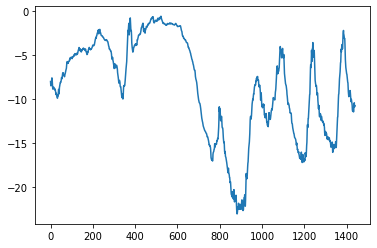

In [5]:
plt.plot(range(1440),temperature[:1440])

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
# 데이터 정규화
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [9]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256, 1)


In [10]:
raw_data.shape[-1]

14

In [11]:
sequence_length

120

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 29ms/step - loss: 17.9458 - mae: 3.2499 - val_loss: 13.3322 - val_mae: 2.8631
Epoch 2/10
819/819 [==============================] - 24s 29ms/step - loss: 11.0146 - mae: 2.6096 - val_loss: 11.6899 - val_mae: 2.7134
Epoch 3/10
819/819 [==============================] - 25s 31ms/step - loss: 9.9736 - mae: 2.4818 - val_loss: 10.7953 - val_mae: 2.6137
Epoch 4/10
819/819 [==============================] - 24s 29ms/step - loss: 9.3157 - mae: 2.3975 - val_loss: 11.0122 - val_mae: 2.6192
Epoch 5/10
819/819 [==============================] - 23s 28ms/step - loss: 8.8119 - mae: 2.3335 - val_loss: 11.1991 - val_mae: 2.6400
Epoch 6/10
819/819 [==============================] - 22s 27ms/step - loss: 8.4399 - mae: 2.2826 - val_loss: 11.8624 - val_mae: 2.7163
Epoch 7/10
819/819 [==============================] - 23s 27ms/step - loss: 8.1186 - mae: 2.2420 - val_loss: 12.1396 - val_mae: 2.7364
Epoch 8/10
819/819 [==============================] -

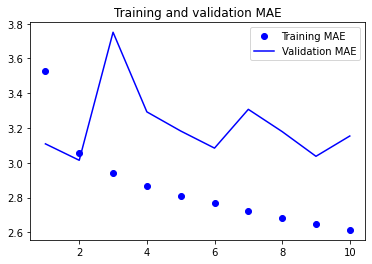

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## 스케일링 적용

StandardScaler, MinMaxScaler와 같은 Scaler 객체를 이용해서 데이터의 스케일링 변환 시에는

fit(), transform(), fit_transform()을 이용한다. 

​

fit()은 데이터 변환을 위한 기준 정보를 설정을 적용하고

transform()은 이렇게 설정된 정보를 이용해서 데이터를 변환한다.

fit_transform()은 fit()과 transform()을 한 번에 적용하는 기능을 수행한다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

train_array = np.arange(0,11).reshape(-1,1)
test_array = np.arange(0,6).reshape(-1,1)

scaler = MinMaxScaler()
scaler.fit(train_array)
train_scaled = scaler.transform(train_array)

print('원본 train_array 데이터 : ',np.round(train_array.reshape(-1),2))
print('Scaled train_array 데이터 : ',np.round(train_scaled.reshape(-1),2))

원본 train_array 데이터 :  [ 0  1  2  3  4  5  6  7  8  9 10]
Scaled train_array 데이터 :  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


학습 데이터는 0~10까지 가지는 이차원 데이터이다.

scaler의 fit, transform은 2차원 이상 데이터에만 가능하기에 reshape(-1,1)로 해줘야 한다.

​

학습 데이터에 MinMaxScaler를 적용하면 최솟값 0, 최댓값 10이기에 1/10 Scale이 적용된다.

In [ ]:
scaler.fit(test_array)
test_scaled = scaler.transform(test_array)

print('원본 test_array 데이터 : ',np.round(test_array.reshape(-1),2))
print('Scaled test_array 데이터 : ',np.round(test_scaled.reshape(-1),2))

원본 test_array 데이터 :  [0 1 2 3 4 5]
Scaled test_array 데이터 :  [0.  0.2 0.4 0.6 0.8 1. ]


이번엔 testdata로 fit을 하고 transform 한 결과를 본다. 테스트 데이터는 최솟값 0 최댓값 5이기에 1/5 스케일이 적용된다.

​

이렇게 되면 학습 데이터와 테스트 데이터의 서로 다른 원본 값이 동일한 값으로 변환되는 결과를 초래한다.

머신러닝 모델은 학습 데이터를 기반으로 학습되기 때문에 반드시 테스트 데이터는 학습 데이터의 스케일링 기준에 따라야 한다. 따라서 테스트 데이터에 다시 fit을 적용해서는 안 되고 학습 데이터로 이미 fit()이 적용된 Scaler 객체를 이용해 transform()으로 변환해야 한다.

In [ ]:
train_array = np.arange(0,11).reshape(-1,1)
test_array = np.arange(0,6).reshape(-1,1)

scaler = MinMaxScaler()
scaler.fit(train_array)
test_scaled = scaler.transform(test_array)

print('원본 test_array 데이터 : ',np.round(test_array.reshape(-1),2))
print('Scaled test_array 데이터 : ',np.round(test_scaled.reshape(-1),2))

원본 test_array 데이터 :  [0 1 2 3 4 5]
Scaled test_array 데이터 :  [0.  0.1 0.2 0.3 0.4 0.5]


test 데이터도 1/10 스케일이 적용된 걸 볼 수 있다.

​

fit_transform()을 적용할 때도 주의해야 한다. fit(), transform()을 순차적으로 수행하기에 학습 데이터에는 상관없지만 테스트 데이터에는 절대로 사용해서는 안 된다. 테스트 데이터에는 transform()만 적용하면 된다.

​

정리

학습 데이터와 테스트 데이터에 fit()과 transform()을 적용할 때 주의 사항이 발생하기에

학습과 테스트 데이터 세트로 분리하기 전에 먼저 전체 데이터 세트에 스케일링을 적용한 뒤 학습과 테스트 데이터 세트로 분리하는 것이 더 좋다.

​

1. 가능하다면 전체 데이터에 스케일링 변환을 적용한 뒤 학습과 테스트 데이터로 분리

2. 1이 안 되면 테스트 변환 시에는 fit()이나 fit_transform()을 적용하지 않고 학습 데이터로 이미 fit() 된 Scaler 객체를 이용해 transform()으로 변환한다.

[과제] 1D 합성곱 모델



In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 30s 28ms/step - loss: 20.3251 - mae: 3.5267 - val_loss: 15.6389 - val_mae: 3.1092
Epoch 2/10
819/819 [==============================] - 24s 29ms/step - loss: 14.7657 - mae: 3.0559 - val_loss: 14.5200 - val_mae: 3.0147
Epoch 3/10
819/819 [==============================] - 24s 29ms/step - loss: 13.7079 - mae: 2.9421 - val_loss: 21.8335 - val_mae: 3.7509
Epoch 4/10
819/819 [==============================] - 23s 28ms/step - loss: 13.0461 - mae: 2.8673 - val_loss: 17.3900 - val_mae: 3.2930
Epoch 5/10
819/819 [==============================] - 24s 29ms/step - loss: 12.5509 - mae: 2.8111 - val_loss: 16.6219 - val_mae: 3.1831
Epoch 6/10
819/819 [==============================] - 22s 27ms/step - loss: 12.1624 - mae: 2.7663 - val_loss: 15.5699 - val_mae: 3.0846
Epoch 7/10
819/819 [==============================] - 24s 30ms/step - loss: 11.8115 - mae: 2.7223 - val_loss: 17.2182 - val_mae: 3.3076
Epoch 8/10
819/819 [============================

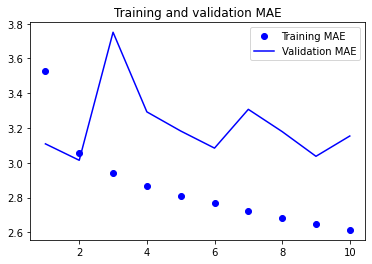

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

[과제] LSTM 기반 모델

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 27s 30ms/step - loss: 45.5234 - mae: 4.9380 - val_loss: 13.4359 - val_mae: 2.7736
Epoch 2/10
819/819 [==============================] - 24s 29ms/step - loss: 11.3830 - mae: 2.6220 - val_loss: 9.6779 - val_mae: 2.4315
Epoch 3/10
819/819 [==============================] - 24s 29ms/step - loss: 10.1129 - mae: 2.4864 - val_loss: 9.7633 - val_mae: 2.4407
Epoch 4/10
819/819 [==============================] - 24s 29ms/step - loss: 9.5780 - mae: 2.4174 - val_loss: 10.1924 - val_mae: 2.4615
Epoch 5/10
819/819 [==============================] - 25s 30ms/step - loss: 9.2753 - mae: 2.3751 - val_loss: 9.6530 - val_mae: 2.4219
Epoch 6/10
819/819 [==============================] - 24s 29ms/step - loss: 9.0690 - mae: 2.3493 - val_loss: 9.7492 - val_mae: 2.4294
Epoch 7/10
819/819 [==============================] - 24s 29ms/step - loss: 8.9386 - mae: 2.3294 - val_loss: 9.7263 - val_mae: 2.4255
Epoch 8/10
819/819 [==============================] - 24s

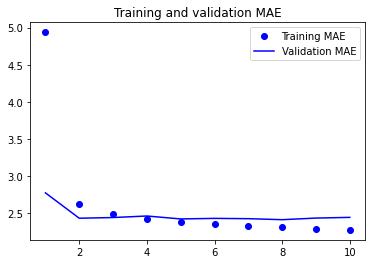

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

[과제] RNN 기반 모델(스태킹)

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
x = layers.SimpleRNN(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs,outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

[과제] 드롭아웃 규제를 적용한 LSTM 모델

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 26s 30ms/step - loss: 28.0783 - mae: 3.9041 - val_loss: 9.8727 - val_mae: 2.4256
Epoch 2/50
819/819 [==============================] - 25s 30ms/step - loss: 14.3081 - mae: 2.9296 - val_loss: 9.5773 - val_mae: 2.3882
Epoch 3/50
819/819 [==============================] - 24s 30ms/step - loss: 13.3836 - mae: 2.8291 - val_loss: 9.7254 - val_mae: 2.4215
Epoch 4/50
819/819 [==============================] - 26s 31ms/step - loss: 12.6561 - mae: 2.7548 - val_loss: 9.4286 - val_mae: 2.3969
Epoch 5/50
819/819 [==============================] - 25s 30ms/step - loss: 12.1966 - mae: 2.7002 - val_loss: 9.5601 - val_mae: 2.4194
Epoch 6/50
819/819 [==============================] - 25s 30ms/step - loss: 11.7881 - mae: 2.6540 - val_loss: 9.7833 - val_mae: 2.4453
Epoch 7/50
819/819 [==============================] - 25s 30ms/step - loss: 11.3548 - mae: 2.6017 - val_loss: 9.7081 - val_mae: 2.4341
Epoch 8/50
819/819 [==============================] - 2

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

[과제] 드롭아웃 규제와 스태킹을 적용한 GRU 모델
GRU모델은 LSTM을 개선한 모델이다. LSTM보다 파라미터가 더욱적어 연산비용도 적고,모델도 간단해 학습속도가 더빠르지만 비슷한 성능을 내는 모델이다

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
# x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
# x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()